# 1. Graph Embedding (Node2Vec) — Data Loading

- Use the official UNSW-NB15 **training** and **testing** CSV files.
- Load from the **current notebook folder**.
- Verify shapes and preview a few rows.


In [1]:
# Let's upload the official training/test CSV files...

from pathlib import Path
import pandas as pd

train_path = Path("UNSW_NB15_training-set.csv")
test_path  = Path("UNSW_NB15_testing-set.csv")


train = pd.read_csv(train_path, low_memory=False)
test  = pd.read_csv(test_path,  low_memory=False)

print("Train:", train.shape, " Test:", test.shape)
display(train.head(3))


Train: (175341, 45)  Test: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0


# 2. Labels and Graph Columns

- Build a binary `label` (1 = attack, 0 = normal) if missing.
- Verify required columns for the graph: `srcip` and `dstip`.
- Keep only rows with valid endpoints.


In [2]:
#  Let's use 'proto' and 'service' as graph endpoints.

SRC, DST = "proto", "service"


avail = set(train.columns)
need  = {SRC, DST}
missing = [c for c in need if c not in avail]
if missing:
    raise KeyError(f"Missing columns: {missing}. Available: {sorted(list(avail))[:15]} ...")

# Let's create edge lists from train/test!
train_edges = (
    
    train[[SRC, DST]]
    .fillna("UNK")
    .astype(str)
    .rename(columns={SRC:"src", DST:"dst"})
)
test_edges = (
    test[[SRC, DST]]
    .fillna("UNK")
    .astype(str)
    .rename(columns={SRC:"src", DST:"dst"})
)


print("Using columns:", SRC, "→", DST)
print("Train edges:", train_edges.shape, "| Test edges:", test_edges.shape)
print("Example edges:\n", train_edges.head())


Using columns: proto → service
Train edges: (175341, 2) | Test edges: (82332, 2)
Example edges:
    src  dst
0  tcp    -
1  tcp    -
2  tcp    -
3  tcp  ftp
4  tcp    -


# 3. Graph Construction and Node Embedding (Node2Vec)

- Built a directed graph using the **official UNSW-NB15** training data.  
- Each edge represents a relationship between **protocol (proto)** and **service** fields.  
- Used the **Node2Vec algorithm** to learn 64-dimensional embeddings for each node (proto/service).  
- Node2Vec captures structural relationships in the network flow metadata using random walks.

In [3]:
# Let's build graphs and analyze node placements (Node2Vec)

import networkx as nx
import numpy as np
import pandas as pd

# we can use the edge list we prepared earlier here.
print("Edges:", train_edges.shape)


G = nx.DiGraph()
G.add_nodes_from(pd.unique(pd.concat([train_edges['src'], train_edges['dst']]).astype(str)))
G.add_edges_from(train_edges.astype(str).itertuples(index=False, name=None))
print("Graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

# Let's install node2vec if missing, then fit!
try:
    from node2vec import Node2Vec
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "node2vec>=0.4.6"])
    from node2vec import Node2Vec

# Node2Vec:

node2vec = Node2Vec(
    G,
    dimensions=64,       # embedding size
    walk_length=20,      # steps per walk
    num_walks=10,        # walks per node
    p=1, q=1,            # DeepWalk when p=q=1
    workers=2,
    seed=42
)
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=256)


# We create a lookup: node to vector...
dim = n2v_model.wv.vector_size
def get_vec(node: str):
    try:
        return n2v_model.wv[str(node)]
    except KeyError:
        return np.zeros(dim, dtype=np.float32)

print("Embedding dim:", dim, "| example vec norm:", np.linalg.norm(get_vec(train_edges.iloc[0,0])))


Edges: (175341, 2)
Graph: 146 nodes, 146 edges


Computing transition probabilities:   0%|          | 0/146 [00:00<?, ?it/s]

Embedding dim: 64 | example vec norm: 0.08634104


Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 5997.00it/s]


# 4. Feature Construction and Classification

- Generated row-level features by concatenating the **source (proto)** and **destination (service)** embeddings (total = 128 dimensions).  
- Trained a **Logistic Regression** model using these embeddings as input features.  
- Evaluated the model on the official test split using **Accuracy**, **Precision**, **Recall**, **F1**, and **ROC-AUC** metrics.  
- Plotted the ROC curve to visualize the classification performance.

GE shapes: (175341, 128) (82332, 128)
{'accuracy': 0.732, 'precision': 0.7308, 'recall': 0.8127, 'f1': 0.7696, 'roc_auc': 0.8145}

Classification report:
               precision    recall  f1-score   support

           0     0.7340    0.6332    0.6799     37000
           1     0.7308    0.8127    0.7696     45332

    accuracy                         0.7320     82332
   macro avg     0.7324    0.7230    0.7247     82332
weighted avg     0.7322    0.7320    0.7293     82332



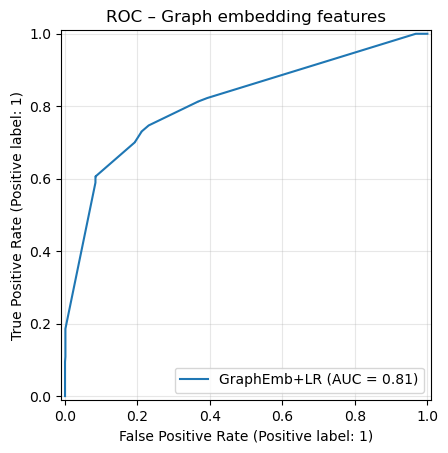

In [4]:
# We build row-level features from embeddings and train a classifier!


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt

#  targets from official split (binary label) 
# If 'label' already exists, we can use it; else derive from 'attack_cat'
def to_label(df):
    if 'label' in df.columns:
        return df['label'].astype(int).values
    assert 'attack_cat' in df.columns
    return (df['attack_cat'].fillna("Normal").str.strip().str.lower() != "normal").astype(int).values

y_tr_ge = to_label(train)
y_te_ge = to_label(test)

# features: concat src/dst embeddings 
def make_edge_features(df_src_dst: pd.DataFrame):
    src_vecs = np.vstack([get_vec(s) for s in df_src_dst['src'].astype(str)])
    dst_vecs = np.vstack([get_vec(d) for d in df_src_dst['dst'].astype(str)])
   
    X = np.hstack([src_vecs, dst_vecs]).astype(np.float32)
    return X

X_tr_ge = make_edge_features(train_edges)
X_te_ge = make_edge_features(test_edges)

print("GE shapes:", X_tr_ge.shape, X_te_ge.shape)

# classifier part...
clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_tr_ge, y_tr_ge)

# evaluate part...
y_pred = clf.predict(X_te_ge)
try:
    y_prob = clf.predict_proba(X_te_ge)[:,1]
    auc = roc_auc_score(y_te_ge, y_prob)
except Exception:
    y_prob, auc = None, np.nan

print({
    "accuracy": round(accuracy_score(y_te_ge, y_pred),4),
    "precision": round(precision_score(y_te_ge, y_pred, zero_division=0),4),
    "recall": round(recall_score(y_te_ge, y_pred, zero_division=0),4),
    "f1": round(f1_score(y_te_ge, y_pred, zero_division=0),4),
    "roc_auc": None if np.isnan(auc) else round(auc,4),
})
print("\nClassification report:\n", classification_report(y_te_ge, y_pred, digits=4, zero_division=0))

# We create ROC curve.
if y_prob is not None:
    RocCurveDisplay.from_predictions(y_te_ge, y_prob, name="GraphEmb+LR")
    plt.title("ROC – Graph embedding features")
    plt.grid(True, alpha=0.3)
    plt.show()
